In [21]:
#!pip install keras-segmentation
#!pip install nibabel
#!pip install --upgrade imgaug
#!pip install --upgrade tensorflow keras
#!pip install keras
#!pip install tensorflow
#!pip install scikit-learn
#!pip install seaborn
#!pip install opencv-python
#!pip install tqdm

In [22]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn
import cv2 as cv
import nibabel as nib
import pickle
import imgaug as ia
import imgaug.augmenters as iaa
import tqdm
import gc
import warnings
import tensorflow as tf
from keras import backend as K
from keras import losses, metrics
from keras import optimizers
from keras import callbacks
from keras.models import Model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Multiply
from sklearn.model_selection import train_test_split
import keras_segmentation as ks

warnings.filterwarnings('ignore')
%matplotlib inline
print("Version: ", tf.version.VERSION)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "not available")

Version:  2.10.1
GPU is available


# 1. Load data file

In [23]:
#Visualize the data set
metadata = pd.read_csv('metadata.csv')
# metadata.replace('../input/covid19-ct-scans/', '', regex=True, inplace=True)
print(metadata.shape)#A total of 20 data sets
metadata.head()

(20, 4)


ct_scan                      lung_mask  \
0  ct_scans/coronacases_org_001.nii  lung_mask/coronacases_001.nii   
1  ct_scans/coronacases_org_002.nii  lung_mask/coronacases_002.nii   
2  ct_scans/coronacases_org_003.nii  lung_mask/coronacases_003.nii   
3  ct_scans/coronacases_org_004.nii  lung_mask/coronacases_004.nii   
4  ct_scans/coronacases_org_005.nii  lung_mask/coronacases_005.nii   

                       infection_mask  \
0  infection_mask/coronacases_001.nii   
1  infection_mask/coronacases_002.nii   
2  infection_mask/coronacases_003.nii   
3  infection_mask/coronacases_004.nii   
4  infection_mask/coronacases_005.nii   

                       lung_and_infection_mask  
0  lung_and_infection_mask/coronacases_001.nii  
1  lung_and_infection_mask/coronacases_002.nii  
2  lung_and_infection_mask/coronacases_003.nii  
3  lung_and_infection_mask/coronacases_004.nii  
4  lung_and_infection_mask/coronacases_005.nii

In [24]:
# Image resizing
img_size = 128

In [25]:
#Equalize the image by dividing the image into small pieces that do not overlap
#To increase the clarity of the image
clahe = cv.createCLAHE(clipLimit=3.0)
#Display image and histogram
def clahe_enhancer(img, clahe, axes):
    img = np.uint8(img*255)  
    clahe_img = clahe.apply(img)

    #The first two columns show the image
    if len(axes) > 0 :    
        axes[0].imshow(img, cmap='bone')
        axes[0].set_title("Original CT scan")
        axes[0].set_xticks([]); axes[0].set_yticks([])

        axes[1].imshow(clahe_img, cmap='bone')
        axes[1].set_title("CLAHE Enhanced CT scan")
        axes[1].set_xticks([]); axes[1].set_yticks([])
    #The third column shows the histogram
        if len(axes) > 2 :
            axes[2].hist(img.flatten(), alpha=0.4, label='Original CT scan')
            axes[2].hist(clahe_img.flatten(), alpha=0.4, label="CLAHE Enhanced CT scan")
            plt.legend()
        
    return(clahe_img)

In [26]:
import os


Number of slices:  301


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


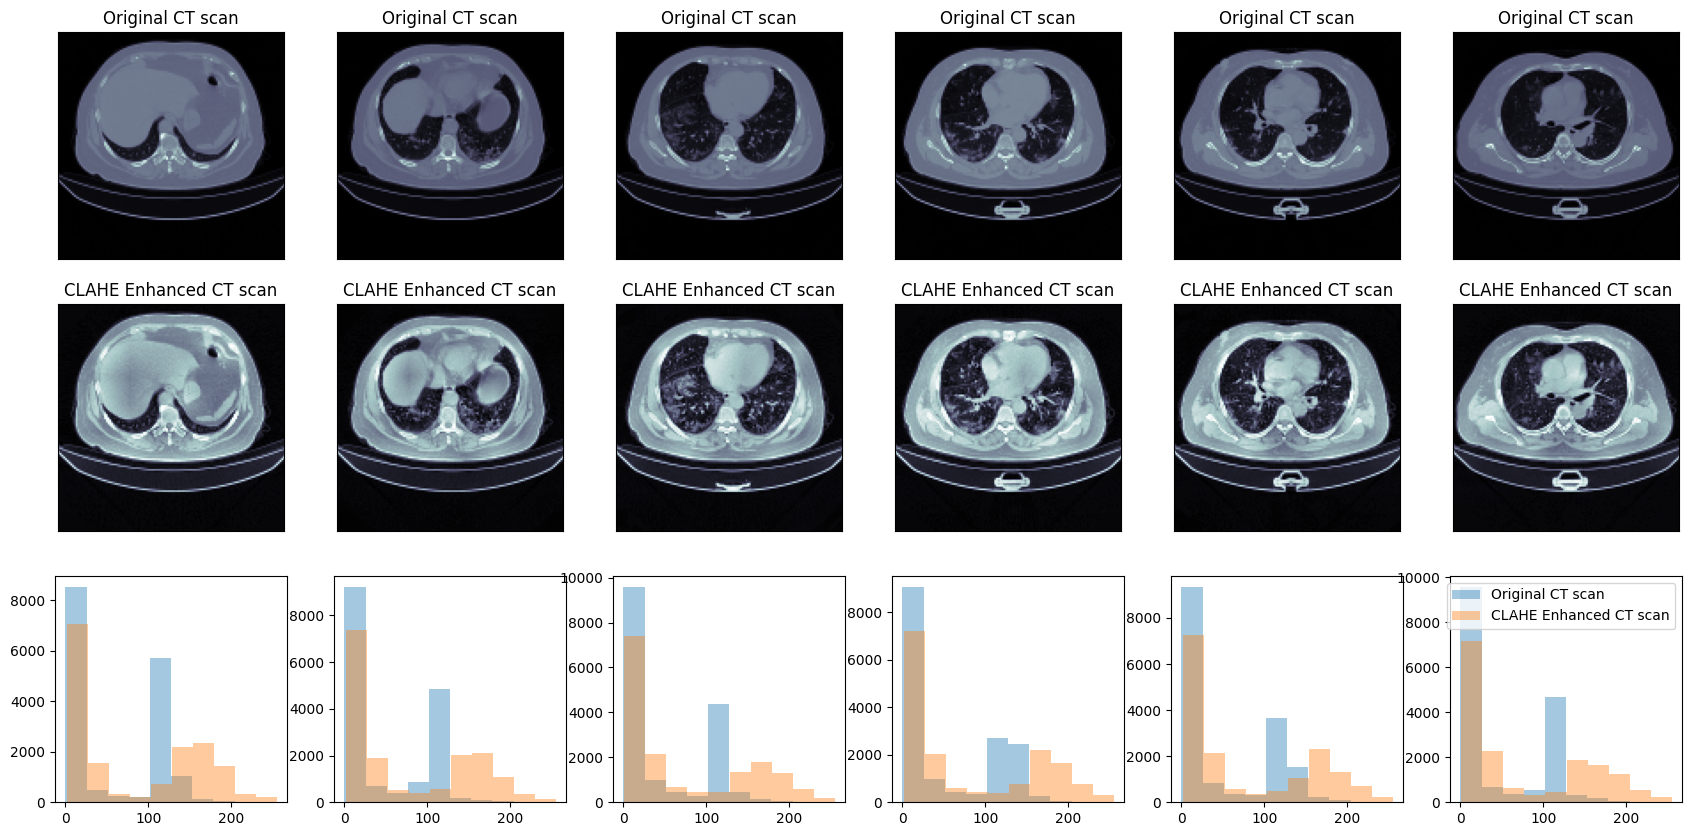

In [27]:
cts = nib.load(metadata.loc[0, 'ct_scan'])#Load the original ct image
slices = cts.shape[2]#维度中的个数
print('Number of slices: ', slices)

#Select display image
arr = cts.get_fdata()
arr = np.rot90(np.array(arr))
arr = arr[:,:,range(80,200,20)]
arr = np.reshape(np.rollaxis(arr, 2),(arr.shape[2],arr.shape[0],arr.shape[1], 1))
#axes is a [3][6] element
fig, axes = plt.subplots(3, 6, figsize=(21,10))  
#print(len(axes[0]))
for ii in range(arr.shape[0]):
    img = cv.resize(arr[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    xmax, xmin = img.max(), img.min()
    img = (img - xmin)/(xmax - xmin)#Picture normalization
    clahe_img = clahe_enhancer(img, clahe, list(axes[:, ii]))

In [28]:
def get_contours(img):
    img = np.uint8(img*255)
    
    kernel = np.ones((3,3),np.float32)/9
    img = cv.filter2D(img, -1, kernel)#Convolution operation
    
    ret, thresh = cv.threshold(img, 50, 255, cv.THRESH_BINARY)
    contours, hierarchy = cv.findContours(thresh, 2, 1)#Get image outline
    #Areas = [cv.contourArea(cc) for cc in contours]; print(Areas)
    
    # Filter out contours that are too large or too small to filter out contours that are too large or too small
    size = get_size(img)#Image area
    contours = [cc for cc in contours if contourOK(cc, size)]
    return contours

def get_size(img):
    ih, iw = img.shape
    return iw * ih

def contourOK(cc, size):
    x, y, w, h = cv.boundingRect(cc)
    if ((w < 50 and h > 150) or (w > 150 and h < 50)) : 
        return False # too narrow or wide is bad
    area = cv.contourArea(cc)
    return area < (size * 0.5) and area > 200

def find_boundaries(img, contours):
    # Edge is the minimum distance from the edge of the image, as a fraction
    ih, iw = img.shape
    minx = iw
    miny = ih
    maxx = 0
    maxy = 0

    for cc in contours:
        x, y, w, h = cv.boundingRect(cc)
        if x < minx: minx = x
        if y < miny: miny = y
        if x + w > maxx: maxx = x + w
        if y + h > maxy: maxy = y + h

    return (minx, miny, maxx, maxy)

def crop_(img, boundaries):
    minx, miny, maxx, maxy = boundaries
    return img[miny:maxy, minx:maxx]
    
def crop_img(img, axes) :
    contours = get_contours(img)
    #plt.figure() # uncomment to troubleshoot
    #canvas = np.zeros_like(img)
    #cv.drawContours(canvas , contours, -1, (255, 255, 0), 1)
    #plt.imshow(canvas)
    bounds = find_boundaries(img, contours)
    cropped_img = crop_(img, bounds)
    
    if len(axes) > 0 :
        axes[0].imshow(img, cmap='bone')
        axes[0].set_title("Original CT scan")
        axes[0].set_xticks([]); axes[0].set_yticks([])
        
        axes[1].imshow(cropped_img, cmap='bone')
        axes[1].set_title("Cropped CT scan")
        axes[1].set_xticks([]); axes[1].set_yticks([])
        
    return cropped_img, bounds
    


Number of slices:  301


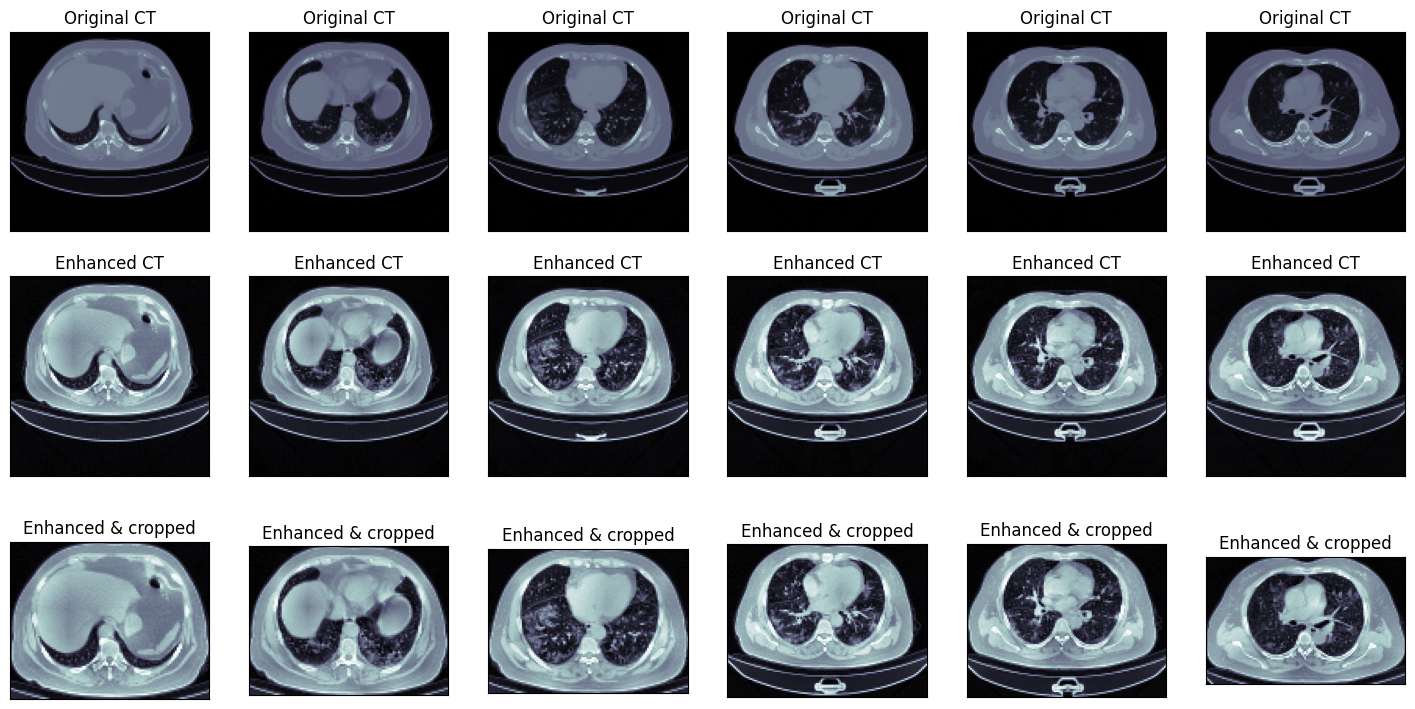

In [29]:
#Load data again
cts = nib.load(metadata.loc[0, 'ct_scan'])
slices = cts.shape[2]
print('Number of slices: ', slices)
    
arr = cts.get_fdata()
arr = np.rot90(np.array(arr))
arr = arr[:,:,range(80,200,20)]
arr = np.reshape(np.rollaxis(arr, 2),(arr.shape[2],arr.shape[0],arr.shape[1], 1))

fig, axes = plt.subplots(3, 6, figsize=(18,9))    

for ii in range(arr.shape[0]):
    img = cv.resize(arr[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    xmax, xmin = img.max(), img.min()
    img = (img - xmin)/(xmax - xmin)#Image normalization
    _, bounds = crop_img(img, [])#
    axes[0,ii].imshow(img, cmap='bone')
    axes[0,ii].set_title('Original CT')#The original image
    axes[0,ii].set_xticks([]); axes[0,ii].set_yticks([])
    
    clahe_img = clahe_enhancer(img, clahe, [])#Equalize the image
    axes[1,ii].imshow(clahe_img, cmap='bone')
    axes[1,ii].set_title('Enhanced CT')
    axes[1,ii].set_xticks([]); axes[1,ii].set_yticks([])
    
    cropped_img = crop_(clahe_img, bounds)#Crop the equalized image to remove unnecessary borders
    axes[2,ii].imshow(cropped_img, cmap='bone')
    axes[2,ii].set_title('Enhanced & cropped')
    axes[2,ii].set_xticks([]); axes[2,ii].set_yticks([])

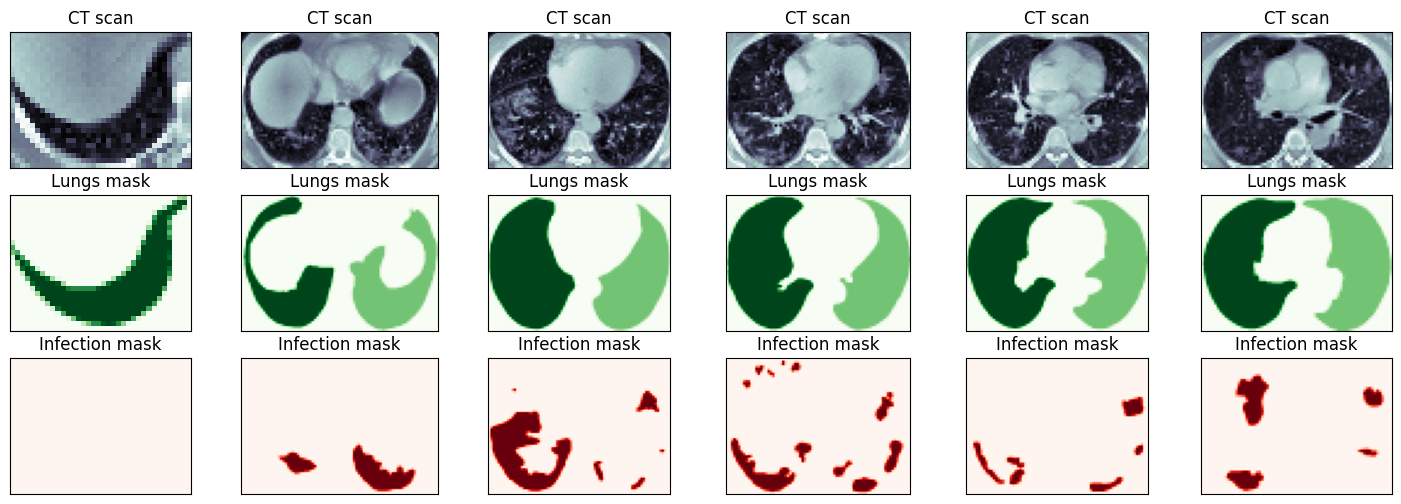

In [30]:
#Import the mask pictures together and show the processed three pictures
cts = nib.load(metadata.loc[0, 'ct_scan'])
lungs = nib.load(metadata.loc[0, 'lung_mask'])
infec = nib.load(metadata.loc[0, 'infection_mask'])
slices = cts.shape[2]
    
arr_cts = cts.get_fdata()
arr_lungs = lungs.get_fdata()
arr_infec = infec.get_fdata()

arr_cts = np.rot90(np.array(arr_cts))
arr_lungs = np.rot90(np.array(arr_lungs))
arr_infec = np.rot90(np.array(arr_infec))

arr_cts = arr_cts[:, :, range(80,200,20)]
arr_lungs = arr_lungs[:, :, range(80,200,20)]
arr_infec = arr_infec[:, :, range(80,200,20)]

arr_cts = np.reshape(np.rollaxis(arr_cts, 2), 
                     (arr_cts.shape[2],arr_cts.shape[0],arr_cts.shape[1], 1))
arr_lungs = np.reshape(np.rollaxis(arr_lungs, 2), 
                     (arr_lungs.shape[2],arr_lungs.shape[0],arr_lungs.shape[1], 1))
arr_infec = np.reshape(np.rollaxis(arr_infec, 2), 
                     (arr_infec.shape[2],arr_infec.shape[0],arr_infec.shape[1], 1))

fig, axes = plt.subplots(3, 6, figsize=(18,6))    

for ii in range(arr_cts.shape[0]):
    img_ct = cv.resize(arr_cts[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    img_lungs = cv.resize(arr_lungs[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    img_infec = cv.resize(arr_infec[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)

    xmax, xmin = img_lungs.max(), img_lungs.min()#归一化
    img_lungs = (img_lungs - xmin)/(xmax - xmin)
    cropped_lungs, bounds = crop_img(img_lungs, [])#边界
    
    xmax, xmin = img_ct.max(), img_ct.min()
    img_ct = (img_ct - xmin)/(xmax - xmin)
    clahe_ct = clahe_enhancer(img_ct, clahe, [])
    cropped_ct = crop_(clahe_ct, bounds)
    cropped_infec = crop_(img_infec, bounds)
    
    axes[0,ii].imshow(cropped_ct, cmap='bone')
    axes[0,ii].set_title("CT scan")
    axes[0,ii].set_xticks([]); axes[0,ii].set_yticks([])
    
    axes[1,ii].imshow(cropped_lungs, cmap='Greens')
    axes[1,ii].set_title("Lungs mask")
    axes[1,ii].set_xticks([]); axes[1,ii].set_yticks([])

    axes[2,ii].imshow(cropped_infec, cmap='Reds')
    axes[2,ii].set_title("Infection mask")
    axes[2,ii].set_xticks([]); axes[2,ii].set_yticks([])

## Load all pictures

In [31]:
cts_all = []
lungs_all = []
infects_all = []
max_w, max_h = 0, 0 #max width and height

for fnum in tqdm.tqdm(range(20)) : #range(metadata.shape[0])) :
    cts = nib.load(metadata.loc[fnum, 'ct_scan'])
    lungs = nib.load(metadata.loc[fnum, 'lung_mask'])
    infec = nib.load(metadata.loc[fnum, 'infection_mask'])
    
    slices = cts.shape[2]

    arr_cts = cts.get_fdata()
    arr_lungs = lungs.get_fdata()
    arr_infec = infec.get_fdata()

    arr_cts = np.rot90(np.array(arr_cts))
    arr_lungs = np.rot90(np.array(arr_lungs))
    arr_infec = np.rot90(np.array(arr_infec))

    arr_cts = arr_cts[:, :, round(slices*0.2):round(slices*0.8)]
    arr_lungs = arr_lungs[:, :, round(slices*0.2):round(slices*0.8)]
    arr_infec = arr_infec[:, :, round(slices*0.2):round(slices*0.8)]

    arr_cts = np.reshape(np.rollaxis(arr_cts, 2), 
                     (arr_cts.shape[2],arr_cts.shape[0],arr_cts.shape[1], 1))
    arr_lungs = np.reshape(np.rollaxis(arr_lungs, 2), 
                     (arr_lungs.shape[2],arr_lungs.shape[0],arr_lungs.shape[1], 1))
    arr_infec = np.reshape(np.rollaxis(arr_infec, 2), 
                     (arr_infec.shape[2],arr_infec.shape[0],arr_infec.shape[1], 1))
    
    for ii in range(arr_cts.shape[0]):
        img_lungs = cv.resize(arr_lungs[ii], dsize=(img_size, img_size), 
                              interpolation=cv.INTER_AREA)
        xmax, xmin = img_lungs.max(), img_lungs.min()
        img_lungs = (img_lungs - xmin)/(xmax - xmin)
        cropped_lungs, bounds = crop_img(img_lungs, [])
        lungs_all.append(cropped_lungs)
        
        h, w = cropped_img.shape
        max_h, max_w = max(max_h, h), max(max_w, w)

        img_ct = cv.resize(arr_cts[ii], dsize=(img_size, img_size), 
                           interpolation=cv.INTER_AREA)
        xmax, xmin = img_ct.max(), img_ct.min()
        img_ct = (img_ct - xmin)/(xmax - xmin)
        clahe_ct = clahe_enhancer(img_ct, clahe, [])
        cropped_ct = crop_(clahe_ct, bounds)
        cts_all.append(cropped_ct)

        img_infec = cv.resize(arr_infec[ii], dsize=(img_size, img_size), 
                              interpolation=cv.INTER_AREA)
        cropped_infec = crop_(img_infec, bounds)
        infects_all.append(cropped_infec)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.16s/it]


In [32]:
print(len(cts_all))

2112


## Resize and reshape

In [33]:
num_pix = 100
del_lst = []
for ii in tqdm.tqdm(range(len(cts_all))) :
    try :
        cts_all[ii] = cv.resize(cts_all[ii], dsize=(num_pix, num_pix), interpolation=cv.INTER_AREA)
        cts_all[ii] = np.reshape(cts_all[ii], (num_pix, num_pix, 1))

        lungs_all[ii] = cv.resize(lungs_all[ii], dsize=(num_pix, num_pix), interpolation=cv.INTER_AREA)
        lungs_all[ii] = np.reshape(lungs_all[ii], (num_pix, num_pix, 1))

        infects_all[ii] = cv.resize(infects_all[ii], dsize=(num_pix, num_pix), interpolation=cv.INTER_AREA)
        infects_all[ii] = np.reshape(infects_all[ii], (num_pix, num_pix, 1))
    except :
        del_lst.append(ii)
        
for idx in del_lst[::-1] :
    del cts_all[idx]
    del lungs_all[idx]
    del infects_all[idx]

100%|████████████████████████████████████████████████████████████████████████████| 2112/2112 [00:00<00:00, 8977.06it/s]


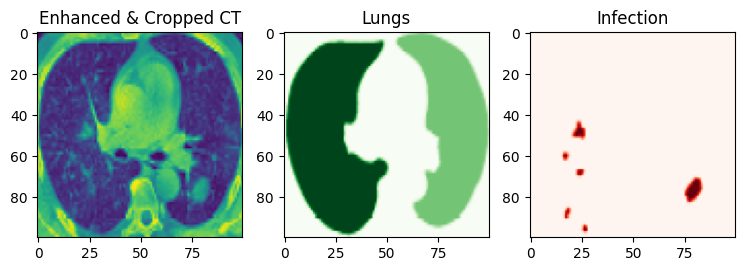

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(9,3))

axes[0].imshow(cts_all[250][:, :, 0])
axes[0].set_title("Enhanced & Cropped CT")

axes[1].imshow(lungs_all[250][:, :, 0], cmap='Greens')
axes[1].set_title("Lungs")

axes[2].imshow(infects_all[250][:, :, 0], cmap='Reds')
axes[2].set_title("Infection");

## Dump preprocessed data

In [35]:
with open('preprocessed_cts.cp', 'wb') as myfile:
    pickle.dump({'cts_all': cts_all, 'lungs_all': lungs_all, 'infects_all': infects_all}, myfile)

In [36]:
infect_bool = np.ones((1, len(infects_all)))
for ii in range(len(infects_all)):
    if np.unique(infects_all[ii]).size == 1:
        infect_bool[0, ii] = 0
        
print("Number of CTs with no infection: %d" %(len(infects_all)-infect_bool.sum()))

#for index in sorted(no_masks, reverse = True):  
#    del infections[index]  
#    del cts[index]

Number of CTs with no infection: 474


* Notice how the infection can be distinguised clearly after enhancement.

* Saving the numpy arrays to later reuse the same preprocessing for other models rather than doing it again.

## Data augmentation pipeline

* Pay attention to how to clearly distinguish the infection after the enhancement.

* Save the numpy array so that you can reuse the same preprocessing in other models later instead of doing it again.

## Data enhancement pipeline

In [37]:
ia.seed(1)

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Flipud(0.5), # vertical flips
    
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-15, 15),
        shear=(-15, 15)
    )
], random_order=True) # apply augmenters in random order

In [38]:
num_augs = round(len(cts_all)/2.)
rand_idx = np.random.randint(0, len(cts_all), size=num_augs)

sample_cts = [cts_all[ii] for ii in rand_idx]
sample_lungs = [lungs_all[ii] for ii in rand_idx]
sample_infects = [infects_all[ii] for ii in rand_idx]

In [39]:
seq_det = seq.to_deterministic()
cts_aug = seq_det.augment_images(sample_cts)
lungs_aug = seq_det.augment_images(sample_lungs)
infects_aug = seq_det.augment_images(sample_infects)

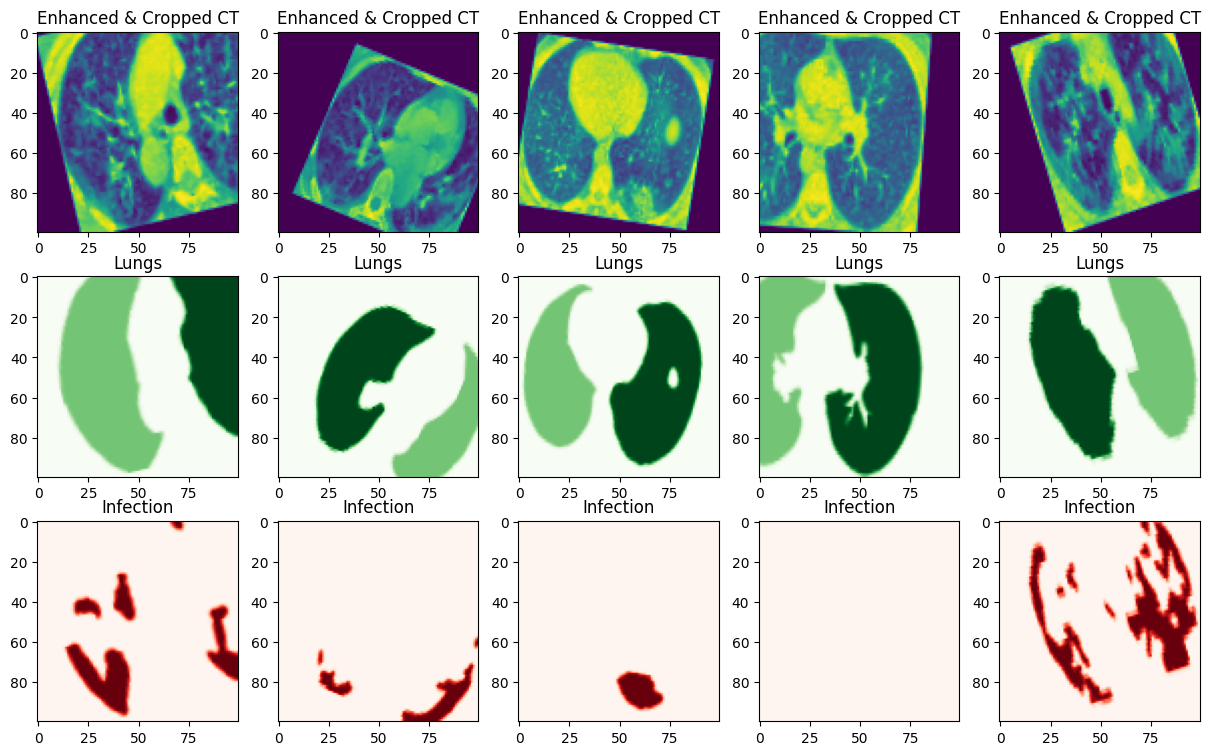

In [40]:
fig, axes = plt.subplots(3, 5, figsize=(15,9))

for ii in range(5) :
    axes[0, ii].imshow(cts_aug[ii*10+50][:, :, 0])
    axes[0, ii].set_title("Enhanced & Cropped CT")

    axes[1, ii].imshow(lungs_aug[ii*10+50][:, :, 0], cmap='Greens')
    axes[1, ii].set_title("Lungs")

    axes[2, ii].imshow(infects_aug[ii*10+50][:, :, 0], cmap='Reds')
    axes[2, ii].set_title("Infection");

## Pool augmented data and convert it

In [41]:
cts_all = tf.convert_to_tensor(cts_all)
cts_aug = tf.convert_to_tensor(cts_aug)
lungs_all = tf.convert_to_tensor(lungs_all)
lungs_aug = tf.convert_to_tensor(lungs_aug)
infects_all = tf.convert_to_tensor(infects_all)
infects_aug = tf.convert_to_tensor(infects_aug)

cts = tf.concat([cts_all, cts_aug], axis=0)
lungs = tf.concat([lungs_all, lungs_aug], axis=0)
infects = tf.concat([infects_all, infects_aug], axis=0)

In [42]:
indices = tf.range(start=0, limit=cts.shape[0], dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices)
                       
cts = tf.gather(cts, shuffled_indices)
lungs = tf.gather(lungs, shuffled_indices)
infects = tf.gather(infects, shuffled_indices)

print(cts.shape, lungs.shape, infects.shape)

(3101, 100, 100, 1) (3101, 100, 100, 1) (3101, 100, 100, 1)


## Save augmented data

In [43]:
with open('augmented_cts.cp', 'wb') as myfile:
    pickle.dump({'cts': cts, 'lungs': lungs, 'infects': infects}, myfile)

* Just cover the infected part on the corresponding CT scan image and mark it

In [44]:
def plot_cts_infects(ct, infect, axes) :

    axes[0].imshow(ct[:,:,0], cmap='bone')
    axes[0].set_title('CT image')

    axes[1].imshow(ct[:,:,0], cmap='bone')
    axes[1].imshow(infect[:,:,0], alpha=0.5, cmap='nipy_spectral')
    axes[1].set_title('Infection')

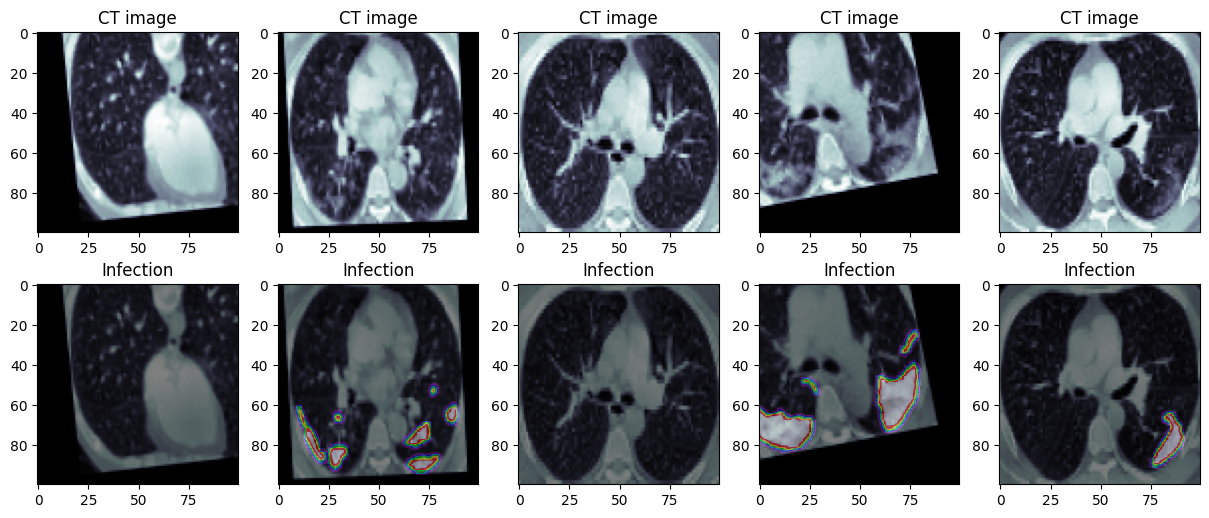

In [45]:
fig, axes = plt.subplots(2, 5, figsize=(15,6))

for ii, idx in enumerate(range(150, 350, 40)) :
    plot_cts_infects(cts[idx], infects[idx], list(axes[:,ii]))

In [46]:
def dice_coeff(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred): #Binary Cross-Entropy
    loss = 0.5*losses.binary_crossentropy(y_true, y_pred) + 0.5*dice_loss(y_true, y_pred)
    return loss

def tversky_loss(y_true, y_pred):
    alpha, beta  = 0.5, 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred
    p1 = ones-y_pred
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2))
    den = num + alpha*K.sum(p0*g1,(0,1,2)) + beta*K.sum(p1*g0,(0,1,2))
    
    T = K.sum(num/den) 
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + 
                     K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1*m2)
    score = (2.*K.sum(w*intersection) + smooth) / (K.sum(w*m1) + K.sum(w*m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    averaged_mask = K.pool2d(y_true, pool_size=(50, 50), strides=(1, 1), 
                             padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5.*K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = 0.5*weighted_bce_loss(y_true, y_pred, weight) + 0.5*dice_loss(y_true, y_pred)
    return loss

## Cosine Annealing Learning Rate

An effective snapshot ensemble requires training a neural network with an aggressive learning rate schedule.

The cosine annealing schedule is an example of an aggressive learning rate schedule where learning rate starts high and is dropped relatively rapidly to a minimum value near zero before being increased again to the maximum.

We can implement the schedule as described in the 2017 paper “Snapshot Ensembles: Train 1, get M for free.” The equation requires the total training epochs, maximum learning rate, and number of cycles as arguments as well as the current epoch number. The function then returns the learning rate for the given epoch.

See https://machinelearningmastery.com/snapshot-ensemble-deep-learning-neural-network/

Cosine annealing learning rate An effective snapshot collection requires training a neural network with an aggressive learning rate plan.

Cosine annealing scheduling is an example of active learning rate scheduling. In this scheduling, the learning rate is high at first, then relatively quickly drops to a minimum value close to zero, and then rises to the maximum value again.

We can implement it in accordance with the schedule described in the 2017 paper "Snapshot Integration: 1 Train, Free M". "The equation requires the total training period, the maximum learning rate, and the number of cycles, as well as the current number of epochs. Then the function returns the learning rate for a given epoch.

See https://machinelearningmastery.com/snapshot-ensemble-deep-learning-neural-network/

In [47]:
# define custom learning rate schedule
class CosineAnnealingLearningRateSchedule(callbacks.Callback):
    # constructor
    def __init__(self, n_epochs, n_cycles, lrate_max, verbose=0):
        self.epochs = n_epochs
        self.cycles = n_cycles
        self.lr_max = lrate_max
        self.lrates = list()
 
    # calculate learning rate for an epoch
    def cosine_annealing(self, epoch, n_epochs, n_cycles, lrate_max):
        epochs_per_cycle = np.floor(n_epochs/n_cycles)
        cos_inner = (np.pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
        return lrate_max/2 * (np.cos(cos_inner) + 1)
 
    # calculate and set learning rate at the start of the epoch
    def on_epoch_begin(self, epoch, logs=None):
        # calculate learning rate
        lr = self.cosine_annealing(epoch, self.epochs, self.cycles, self.lr_max)
        # set learning rate
        K.set_value(self.model.optimizer.lr, lr)
        # log value
        self.lrates.append(lr)

In [49]:
# define learning rate callback
n_epochs = 200
lrmax = 0.002
n_cycles = n_epochs / 25
lr_cb = CosineAnnealingLearningRateSchedule(n_epochs, n_cycles, lrmax)

# Model building blocks

In [50]:
def cts_block_1 (x_in, conv2Dfilters, maxpool2Dsize=(2,2)) :
    x = Conv2D(conv2Dfilters, (3,3), activation='relu', padding='same', 
               kernel_initializer="he_normal") (x_in)
    x = Conv2D(conv2Dfilters, (3, 3), activation='relu', padding='same', 
               kernel_initializer="he_normal") (x)
    x_inter = BatchNormalization() (x)
    x = MaxPooling2D(maxpool2Dsize) (x_inter) 
    x = Dropout(0.25)(x) 
    
    return x, x_inter

def cts_block_2 (x_in, conv2Dfilters) :
    x = BatchNormalization() (x_in)
    x = Conv2D(conv2Dfilters, (3, 3), activation='relu', padding='same', 
               kernel_initializer="he_normal") (x)
    x = Conv2D(conv2Dfilters, (3, 3), activation='relu', padding='same', 
               kernel_initializer="he_normal") (x) 
    
    return x

# keras model with one input (CTs) and two segmented output (lungs & infections)

In [51]:
def cts_model (input_shape) :
    
    x_input = Input(input_shape)
    
    ################################## Lung segmentation  ######################
    x, x1 = cts_block_1 (x_input, 32, maxpool2Dsize=(2,2)) #x: 50x50
    x, x2 = cts_block_1 (x, 64, maxpool2Dsize=(2,2)) #x: 25x25
    x, _ = cts_block_1 (x, 128, maxpool2Dsize=(1,1)) #x: 25x25
    x, _ = cts_block_1 (x, 256, maxpool2Dsize=(1,1)) #x: 25x25

    x = cts_block_2 (x, 256) #x: 25x25
    
    x = Conv2DTranspose(128, (2, 2), strides=(2,2), padding='same') (x) #x: 50x50
    x = cts_block_2 (x, 128) #x: 50x50

    x = Conv2DTranspose(64, (2, 2), padding='same') (x) #x: 50x50
    x = concatenate([x, x2]) #x: 50x50
    x = cts_block_2 (x, 64) #x: 50x50

    x = Conv2DTranspose(32, (2, 2), strides=(2,2), padding='same') (x) #x: 100x100
    x = concatenate([x, x1], axis=3) #x: 100x100
    x = cts_block_2 (x, 32) #x: 100x100

    lung_seg = Conv2D(1, (1, 1), activation='sigmoid', name='lung_output') (x) #x: 100x100

    ##################################  Infection segmentation  ######################
    x, x1 = cts_block_1 (lung_seg, 32, maxpool2Dsize=(2,2)) #x: 50x50
    x, x2 = cts_block_1 (x, 64, maxpool2Dsize=(2,2)) #x: 25x25
    x, _ = cts_block_1 (x, 128, maxpool2Dsize=(1,1)) #x: 25x25
    x, _ = cts_block_1 (x, 256, maxpool2Dsize=(1,1)) #x: 25x25
    
    x = cts_block_2 (x, 256) #x: 25x25
    
    x = Conv2DTranspose(128, (2, 2), strides=(2,2), padding='same') (x) #x: 50x50
    x = cts_block_2 (x, 128) #x: 50x50

    x = Conv2DTranspose(64, (2, 2), padding='same') (x) #x: 50x50
    x = concatenate([x, x2]) #x: 50x50
    x = cts_block_2 (x, 64) #x: 50x50

    x = Conv2DTranspose(32, (2, 2), strides=(2,2), padding='same') (x) #x: 100x100
    x = concatenate([x, x1], axis=3) #x: 100x100
    x = cts_block_2 (x, 32) #x: 100x100

    infect_seg = Conv2D(1, (1, 1), activation='sigmoid', name='infect_output') (x) # identifying infections

    model = Model(inputs=x_input, outputs=[lung_seg, infect_seg], name='cts_model')
    
    return model

In [52]:
ctsModel = cts_model(cts.shape[1:])
ctsModel.summary()

Model: "cts_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 100, 100, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 100, 100, 32  9248        ['conv2d[0][0]']                 
                                )                                                         

                                                                                                  
 batch_normalization_13 (Ba  (None, 50, 50, 128)          512       ['conv2d_transpose_3[0][0]']  
 tchNormalization)                                                                                
                                                                                                  
 conv2d_26 (Conv2D)          (None, 50, 50, 128)          147584    ['batch_normalization_13[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_27 (Conv2D)          (None, 50, 50, 128)          147584    ['conv2d_26[0][0]']           
                                                                                                  
 conv2d_transpose_4 (Conv2D  (None, 50, 50, 64)           32832     ['conv2d_27[0][0]']           
 Transpose

## Split data into train and validation sets

In [53]:
train_size = int(0.8*cts.shape[0])
test_size = int(0.1*cts.shape[0])

X_train, yl_train, yi_train = (cts[:train_size]/255, 
                               lungs[:train_size], 
                               infects[:train_size])

X_valid, yl_valid, yi_valid = (cts[train_size:train_size+test_size]/255, 
                               lungs[train_size:train_size+test_size],
                               infects[train_size:train_size+test_size])

X_test, yl_test, yi_test = (cts[train_size+test_size:]/255, 
                            lungs[train_size+test_size:],
                            infects[train_size+test_size:])

print(X_train.shape, yl_train.shape, yi_train.shape)
print(X_test.shape, yl_test.shape, yi_test.shape)

(2480, 100, 100, 1) (2480, 100, 100, 1) (2480, 100, 100, 1)
(311, 100, 100, 1) (311, 100, 100, 1) (311, 100, 100, 1)


In [54]:
batch_size = 32
epochs = n_epochs

checkpoint_fpath = "ctsmodel-lungs-infect-seg.hdf5"
cts_checkpoint_cb = callbacks.ModelCheckpoint(checkpoint_fpath, 
                                              monitor='val_infect_output_dice_coeff', 
                                              save_best_only=True, 
                                              mode='max', 
                                              verbose=1,
                                              save_weights_only=True)

# Training

In [55]:
optim = optimizers.Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.99)

loss_dict = {'lung_output': bce_dice_loss, 'infect_output': bce_dice_loss}
loss_weight_dict = {'lung_output': 1.0, 'infect_output': 1.0}

ctsModel.compile(optimizer=optim, loss=loss_dict, loss_weights=loss_weight_dict, metrics=[dice_coeff])

ctsRes = ctsModel.fit(x=X_train, 
                      y={'lung_output': yl_train, 'infect_output': yi_train}, 
                      batch_size=batch_size, 
                      epochs=epochs,
                      verbose=1,
                      validation_data=(X_valid, 
                                       {'lung_output': yl_valid, 'infect_output': yi_valid}),
                      callbacks = [cts_checkpoint_cb, lr_cb])

Epoch 1/200
78/78 [==============================] - ETA: 0s - loss: 0.7613 - lung_output_loss: 0.3221 - infect_output_loss: 0.4392 - lung_output_dice_coeff: 0.7411 - infect_output_dice_coeff: 0.2812
Epoch 1: val_infect_output_dice_coeff improved from -inf to 0.17244, saving model to ctsmodel-lungs-infect-seg.hdf5
78/78 [==============================] - 31s 256ms/step - loss: 0.7613 - lung_output_loss: 0.3221 - infect_output_loss: 0.4392 - lung_output_dice_coeff: 0.7411 - infect_output_dice_coeff: 0.2812 - val_loss: 11.3930 - val_lung_output_loss: 1.8911 - val_infect_output_loss: 9.5018 - val_lung_output_dice_coeff: 0.5991 - val_infect_output_dice_coeff: 0.1724
Epoch 2/200
78/78 [==============================] - ETA: 0s - loss: 0.6252 - lung_output_loss: 0.2964 - infect_output_loss: 0.3288 - lung_output_dice_coeff: 0.7621 - infect_output_dice_coeff: 0.4918
Epoch 2: val_infect_output_dice_coeff improved from 0.17244 to 0.17270, saving model to ctsmodel-lungs-infect-seg.hdf5
78/78 [===

In [56]:
ctsModel_json = ctsModel.to_json()
with open('ctsModel-lungs-infects.json', 'w') as myfile:
     myfile.write(ctsModel_json)

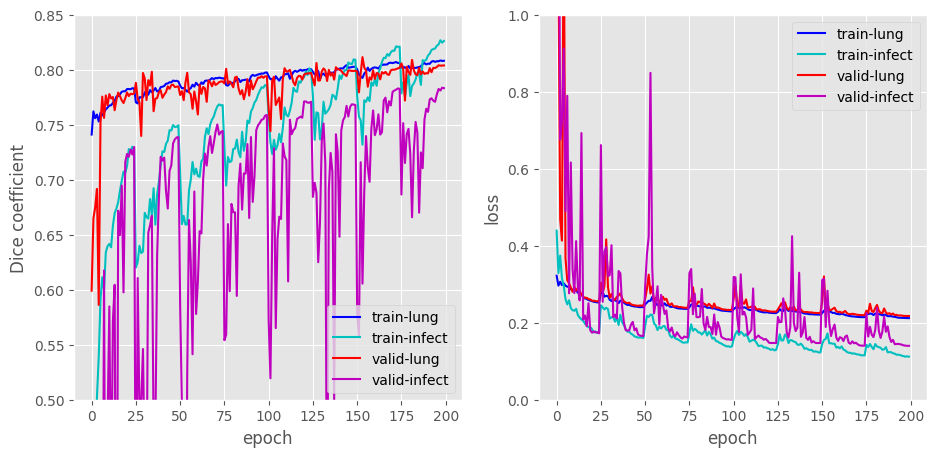

In [57]:
plt.style.use('ggplot')

fig, axes = plt.subplots(1, 2, figsize=(11,5))

axes[0].plot(ctsRes.history['lung_output_dice_coeff'], color='b', label='train-lung')
axes[0].plot(ctsRes.history['infect_output_dice_coeff'], color='c', label='train-infect')
axes[0].plot(ctsRes.history['val_lung_output_dice_coeff'], color='r', label='valid-lung')
axes[0].plot(ctsRes.history['val_infect_output_dice_coeff'], color='m', label='valid-infect')
axes[0].set_ylabel('Dice coefficient')
axes[0].set_xlabel('epoch')
axes[0].legend()
axes[0].set_ylim([0.5, 0.85])

axes[1].plot(ctsRes.history['lung_output_loss'], color='b', label='train-lung')
axes[1].plot(ctsRes.history['infect_output_loss'], color='c', label='train-infect')
axes[1].plot(ctsRes.history['val_lung_output_loss'], color='r', label='valid-lung')
axes[1].plot(ctsRes.history['val_infect_output_loss'], color='m', label='valid-infect')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].set_ylim([0,1])
axes[1].legend();

In [58]:
test_result = ctsModel.evaluate(x=X_test, 
                                y={'lung_output': yl_test, 'infect_output': yi_test},
                                batch_size=batch_size)

print('Test data:\n\t Lung: %.4f loss, %.4f dice coeff\n\t Infection: %.4f loss, %.4f dice coeff' 
      %(test_result[1], test_result[3], test_result[2], test_result[4]))

10/10 [==============================] - 2s 153ms/step - loss: 0.3597 - lung_output_loss: 0.2192 - infect_output_loss: 0.1405 - lung_output_dice_coeff: 0.8076 - infect_output_dice_coeff: 0.7723
Test data:
	 Lung: 0.2192 loss, 0.8076 dice coeff
	 Infection: 0.1405 loss, 0.7723 dice coeff


In [59]:
gc.collect()#Clean up memory

29643

## Run this if you want to train the network more

In [62]:
checkpoint_fpath = "ctsmodel-lungs-infect-seg-2.hdf5"
cts_checkpoint_cb = callbacks.ModelCheckpoint(checkpoint_fpath, 
                                              monitor='val_infect_output_dice_coeff', 
                                              save_best_only=True, 
                                              mode='max', 
                                              verbose=1,
                                              save_weights_only=True)


ctsModel = cts_model(cts.shape[1:])

optim = optimizers.Adam(lr=5e-4, beta_1=0.9, beta_2=0.99)

ctsModel.compile(optimizer=optim, loss=loss_dict, loss_weights=loss_weight_dict, metrics=[dice_coeff])

ctsModel.load_weights('ctsmodel-lungs-infect-seg.hdf5')

ctsRes = ctsModel.fit(x=X_train, 
                      y={'lung_output': yl_train, 'infect_output': yi_train},
                      batch_size=batch_size, 
                      epochs=epochs,
                      validation_data=(X_valid, 
                                       {'lung_output': yl_valid, 
                                        'infect_output': yi_valid}),
                      callbacks = [cts_checkpoint_cb])

Epoch 1/200
78/78 [==============================] - ETA: 0s - loss: 0.3283 - lung_output_loss: 0.2127 - infect_output_loss: 0.1157 - lung_output_dice_coeff: 0.8076 - infect_output_dice_coeff: 0.8195
Epoch 1: val_infect_output_dice_coeff improved from -inf to 0.77704, saving model to ctsmodel-lungs-infect-seg-2.hdf5
78/78 [==============================] - 21s 232ms/step - loss: 0.3283 - lung_output_loss: 0.2127 - infect_output_loss: 0.1157 - lung_output_dice_coeff: 0.8076 - infect_output_dice_coeff: 0.8195 - val_loss: 0.3673 - val_lung_output_loss: 0.2203 - val_infect_output_loss: 0.1470 - val_lung_output_dice_coeff: 0.8026 - val_infect_output_dice_coeff: 0.7770
Epoch 2/200
78/78 [==============================] - ETA: 0s - loss: 0.3277 - lung_output_loss: 0.2129 - infect_output_loss: 0.1148 - lung_output_dice_coeff: 0.8081 - infect_output_dice_coeff: 0.8222
Epoch 2: val_infect_output_dice_coeff did not improve from 0.77704
78/78 [==============================] - 17s 223ms/step - los

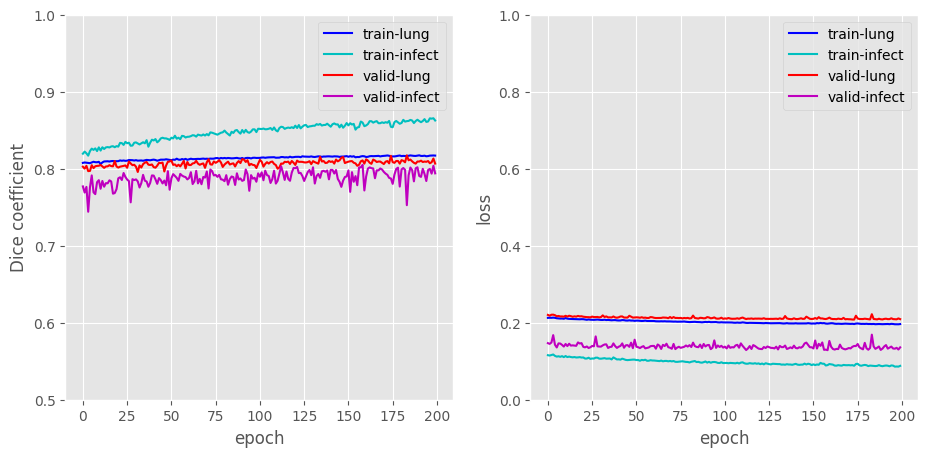

In [63]:
plt.style.use('ggplot')

fig, axes = plt.subplots(1, 2, figsize=(11,5))

axes[0].plot(ctsRes.history['lung_output_dice_coeff'], color='b', label='train-lung')
axes[0].plot(ctsRes.history['infect_output_dice_coeff'], color='c', label='train-infect')
axes[0].plot(ctsRes.history['val_lung_output_dice_coeff'], color='r', label='valid-lung')
axes[0].plot(ctsRes.history['val_infect_output_dice_coeff'], color='m', label='valid-infect')
axes[0].set_ylabel('Dice coefficient')
axes[0].set_xlabel('epoch')
axes[0].legend()
axes[0].set_ylim([0.5, 1])

axes[1].plot(ctsRes.history['lung_output_loss'], color='b', label='train-lung')
axes[1].plot(ctsRes.history['infect_output_loss'], color='c', label='train-infect')
axes[1].plot(ctsRes.history['val_lung_output_loss'], color='r', label='valid-lung')
axes[1].plot(ctsRes.history['val_infect_output_loss'], color='m', label='valid-infect')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].set_ylim([0,1])
axes[1].legend();


In [64]:
test_result = ctsModel.evaluate(x=X_test, 
                                y={'lung_output': yl_test, 'infect_output': yi_test},
                                batch_size=batch_size)

print('Test data:\n\t Lung: %.4f loss, %.4f dice coeff\n\t Infection: %.4f loss, %.4f dice coeff' 
      %(test_result[1], test_result[3], test_result[2], test_result[4]))

10/10 [==============================] - 1s 62ms/step - loss: 0.3405 - lung_output_loss: 0.2103 - infect_output_loss: 0.1302 - lung_output_dice_coeff: 0.8118 - infect_output_dice_coeff: 0.7917
Test data:
	 Lung: 0.2103 loss, 0.8118 dice coeff
	 Infection: 0.1302 loss, 0.7917 dice coeff


In [65]:
# model.compile(optimizer=Adam(lr = 0.0005), loss=bce_dice_loss, metrics=[sm.metrics.IOUScore(threshold=0.55)])

In [66]:
yl_pred, yi_pred = ctsModel.predict(X_test)
print(yl_pred.shape, yi_pred.shape)

10/10 [==============================] - 1s 60ms/step
(311, 100, 100, 1) (311, 100, 100, 1)


## Evaluate network performance

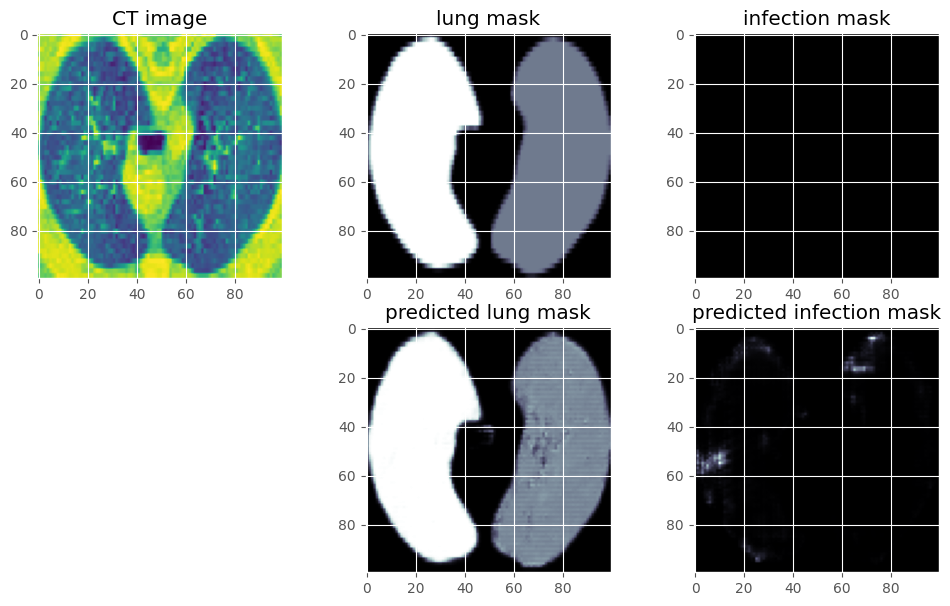

In [67]:
import matplotlib.pyplot as plt
import tensorflow as tf

def compare_actual_and_predicted(img_num):

    fig = plt.figure(figsize=(12,7))

    plt.subplot(2,3,1)
    plt.imshow(tf.reshape(X_test[img_num], [num_pix, num_pix]))
    plt.title('CT image')

    plt.subplot(2,3,2)
    plt.imshow(tf.reshape(yl_test[img_num], [num_pix, num_pix]), cmap='bone')
    plt.title('lung mask')

    plt.subplot(2,3,3)
    plt.imshow(tf.reshape(yi_test[img_num], [num_pix, num_pix]), cmap='bone')
    plt.title('infection mask')

    plt.subplot(2,3,5)
    plt.imshow(tf.reshape(yl_pred[img_num], [num_pix, num_pix]), cmap='bone')
    plt.title('predicted lung mask')

    plt.subplot(2,3,6)
    plt.imshow(tf.reshape(yi_pred[img_num], [num_pix, num_pix]), cmap='bone')
    plt.title('predicted infection mask')
compare_actual_and_predicted(10)

In [68]:
# IoU calculation
intersection = np.logical_and(yi_test[1], yi_pred[1])
union = np.logical_or(yi_test[1], yi_pred[1])
iou_score = np.sum(intersection) / np.sum(union)
print('IoU is %s' % iou_score)

IoU is 0.2114
